In [2]:
import pandas as pd

bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

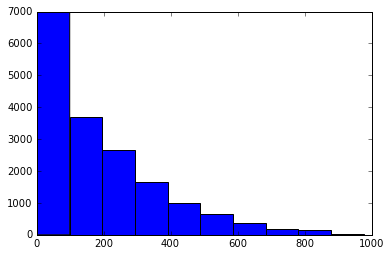

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.hist(bike_rentals['cnt'])

In [4]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [7]:
#starting feature transformation
def assign_label(hour):
    if hour >= 0 and hour < 6:
        return 4
    elif hour >= 6 and hour <12:
        return 1
    elif hour >=12 and hour < 18:
        return 2
    elif hour >= 18 and hour <= 24:
        return 3
    
bike_rentals["time_label"] = bike_rentals['hr'].apply(assign_label)


# Error Metric
The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric, which fits ours quite well

In [8]:
train = bike_rentals.sample(frac = .8)

In [9]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [10]:
from sklearn.linear_model import LinearRegression

predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

reg = LinearRegression()

reg.fit(train[predictors], train["cnt"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
import numpy 

predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

16569.15297607749

MSE is huge as the target is not normally distributed. It has a strong skew, so the outliers are messing with the MSE

In [13]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf =5)

reg.fit(train[predictors], train['cnt'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [15]:
predictions = reg.predict(test[predictors])
numpy.mean((predictions - test['cnt'])**2)

2630.3826083031186

In [16]:
reg = DecisionTreeRegressor(min_samples_leaf=2)

reg.fit(train[predictors], train["cnt"])

predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

2744.231564058305

We aren't killing it, let's use a random forest and account for the non-linear predictors


In [27]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(min_samples_leaf=3)
reg.fit(train[predictors], train["cnt"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [28]:

predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

1691.0266327129839

min_samples_leaf = 3 seems to be optimal for minimizing MSE. We could be more robust with feature transformation to get a better model, but let's stop here